# 16-1. 데이터셋을 어디에서 구할까?

**MPII 데이터셋 다운로드하기**

<br>

오늘은 MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-1.max-800x600.png)

<br>

미리 준비해 둔 데이터를 연결하고 압축을 해제해 주세요.
```
$ mkdir -p ~/aiffel/mpii
$ ln -s ~/data/* ~/aiffel/mpii
$ cd ~/aiffel/mpii
$ tar -xvf mpii_human_pose_v1.tar.gz -C . 
$ unzip mpii_human_pose_v1_u12_2.zip
```

<br>

`mpii_human_pose_v1_u12_2.zip` 을 풀어보면 `mpii_human_pose_v1_u12_1.mat` 파일이 나와서 열어보기 불편한데요. 파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.
```
$ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
```

<br>

mpii.zip

<br>

마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 압축 해제합니다.
```
$ cd ~/aiffel/mpii && unzip mpii.zip
```

<br>

이번 노드에서는 이 프로젝트 파일을 LMS환경에 맞게 편집하여 진행합니다. `.py` 파일 원본을 확인하면 학습에 도움이 되실거예요.

# 16-2. 데이터 전처리하기

앞으로 사용할 라이브러리를 불러옵니다. 고정해서 사용할 변수도 만들어 두죠.

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, 'save models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


**json 파싱하기**

이전 스텝에서 `train.json`과 `validation.json` 파일이 소개된 것을 기억하시나요? 이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있습니다.

<br>

우선 json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 봅시다. `json.dumps()`를 활용해서 좀 더 명확하게 하면 더욱 좋습니다.

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


`joints` 가 우리가 label 로 사용할 keypoint 의 label 입니다. 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 `joints_vis` 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냅니다. MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있습니다. coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있습니다.

<br>

`joints` 순서는 아래와 같은 순서로 배치되어 저장해 뒀습니다.

<br>

- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

<br>

`scale`과 `center`는 사람 몸의 크기와 중심점 입니다.`scale`은 200을 곱해야 온전한 크기가 됩니다. 추후에 전처리 과정에서 200을 곱해서 사용할 예정이에요.

<br>

이제 json annotation 을 파싱하는 함수를 만들어 보겠습니다.

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


한 번 `parse_one_annotation()`함수를 테스트 해봅시다.

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


이제 우리가 원하는 정보만 뽑아낼 수 있게 되었네요. 다음으로 넘어가보죠.

# 16-3. TFRecord 파일 만들기

**TFRecord 파일 만들기**

<br>

이전까지는 tf.keras 의 `ImageDataGenerator` 를 이용해서 주로 학습 데이터를 읽었습니다. 하지만 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 합니다.

<br>

학습을 많이 해볼수록 학습 속도에 관심을 가지게 되는데요. [tensorflow 튜토리얼 문서](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=en)에는 다음과 같은 표현으로 나타나 있습니다.

<br>

> unless you are using tf.data and reading data is still the bottleneck to training.

<br>

일반적으로 학습 과정에서 gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있습니다. (답답해요..)

<br>

따라서 "학습 데이터를 어떻게 빠르게 읽는가?" 에 대한 고민을 반드시 수행하셔야 더 많은 실험을 할 수 있습니다.

<br>

다음 링크를 보고 퀴즈를 풀어 봅시다.

<br>

- [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)

<br>

> Q1. 학습 속도를 향상시키기 위해서 데이터 관점에서 고려해야하는 단계는 어떤 단계인가요? 속도 향상을 위한 처리 방법을 위 링크에서 찾아대답해 봅시다.<br><br>
data read(또는 prefetch) 또는 데이터 변환 단계. gpu 학습과 병렬적으로 수행되도록 prefetch를 적용해야 함. 수행방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법을 사용해야함.

<br>

내용이 꽤 어렵습니다만 tf 에서는 위 변환을 자동화해주는 도구를 제공합니다. 데이터셋을 TFRecord 형태로 표현하는 것인데요. TFRecord 는 binary record sequence 를 저장하기 위한 형식입니다.

<br>

내부적으로 protocol buffer 라는 것을 이용합니다.

<br>

- https://developers.google.com/protocol-buffers/?hl=ko

<br>
protocol buffer 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하시면 됩니다.

<br>

데이터를 직렬화 한다는 것은 의미가 있는 정보만 추출해 나열하는 것을 뜻합니다. 예를 들어 "서울 강동구에 사는 32살 고길동"님을 나타내기 위해 "서울강동32고길동"과 같이 쓴다면 데이터만 담을 수 있겠죠? 다만 데이터 형식을 고정해야 하기 때문에 첫 두 글자는 시를 뜻하고, 다음 두 글자는 구를 뜻하고 다음 두 자리 숫자가 오고 이름은 세 글자여야 하는 제한이 생깁니다. 100살이 넘는 사람이나 이름이 세 글자가 아닌 사람을 담을 수 없어요. 그래서 매우 정형화된 데이터는 직렬화 하면 데이터 크기와 처리 속도 측면에서 유리하지만 사용하는데 제한이 있다고 기억하면 좋습니다. 어떤 데이터에서 어떤 방법으로 직렬화를 수행할지에 따라 발생되는 제한이 달라질 수도 있고요.

<br>

이제 구현을 시작하겠습니다. 하나하나 천천히 가보죠. 앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들게요. TFRecord 는 `tf.train.Example`들의 합으로 이루어지므로 하나의 annotation을 하나의 `tf.train.Example`로 만들어 주는 함수부터 작성합니다.

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


하나의 annotation이 `tf.train.Example`이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수를 만들어야 합니다.

<br>

그런데 여기서 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들어 볼 거예요. 우선 얼마나 많은 TFRecord를 만들지 결정할 함수를 만들게요.

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


이 함수는 전체 데이터를 몇 개의 그룹으로 나눌지 결정해 줍니다. 전체 데이터 `l`을 `n`그룹으로 나눕니다. 결과적으로 n개의 TFRecord 파일을 만들겠다는 이야기입니다.

<br>

여기서 좀 더 전문적으로는 `n`개로 **shard** 했다고 말합니다. 기업 단위의 데이터는 매우 크고 여러 장비에 나누어져 있기 때문에 sharding은 자주 이루어 집니다. 하나의 큰 데이터를 여러 개의 파일로 쪼개고 여러 컴퓨터에 나누어 담는 것이라고 여기면 됩니다. 이렇게 하면 데이터 저장에도 용이하고 병렬 처리에 하는데 이점이 있습니다.

<br>

이 때, 이 데이터는 원래 하나의 큰 데이터였기 때문에 저장 후 어떻게 사용할 것인가에 따라서 sharding 전략이 달라지는데요. 그 내용을 다루기에는 너무 방대하니 여기서는 간단히만 다룹니다. 모델을 학습하는데 각 파일의 크기와 개수만 고려해보면, 너무 작은 파일로 많이 나누는 것도, 너무 큰 파일로 적게 나누는 것도 좋지 않습니다. 너무 작은 파일로 많이 나누면 학습 중간에 너무 잦은 입출력이 요구되고, 너무 큰 파일로 적게 나누면 입출력마다 걸리는 시간이 길어집니다. 입출력에 걸리는 시간이 GPU의 계산 시간보다 길어지면 그만큼 손해가 됩니다. 적절한 파일 크기와 개수는 케바케라고 할 수 있어요.

<br>

아래 링크를 보고 퀴즈를 풀어 봅시다.

<br>

- [TFRecord 및 tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko)

> Q2. annotation 을 왜 shard 로 나눠야할까요? 위 링크를 참고해서 대답해 봅시다.<br><br>
I/O 병목을 피하기 위해 입력 파일을 여러개로 나눈 뒤, 병렬적으로 prefetch 하는 것이 학습 속도를 빠르게 합니다. 튜토리얼에서는 경험상 데이터를 읽는 호스트보다 최소 10 배 많은 파일을 보유하는 것이 좋습니다. 동시에 각 파일은 I / O 프리 페치의 이점을 누릴 수 있도록 충분히 커야합니다 (최소 10MB 이상, 이상적으로는 100MB 이상) 이라고 친절하게 사용 팁을 알려주고 있습니다.

<br>

설명은 어렵지만 실행해보면 단순합니다. 그럼 `chunkify`함수를 테스트 해볼까요?

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

0이 1000개 들어 있는 리스트가 64개로 쪼개졌네요. `chunkify` 함수를 테스트 해봤으니 하나의 chunk를 TFRecord로 만들어 줄 함수를 만듭시다.

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


`chun`k안에는 여러 annotation들이 있고, annotation들은 `tf.train.Example`로 변환된 후에 문자열로 직렬화되어 TFRecord에 담기는군요.

<br>

또 한 가지 주의해서 봐야할 것은 함수 정의 위에 `@ray.remote`가 있다는 점이예요.

<br>

- [RAY](https://www.ray.io/)

<br>

Ray는 병렬 처리를 위한 라이브러리인데요. 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있습니다.

<br>

이제 모든 준비가 되었으니 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수를 만듭시다. ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다는 점에 주의하세요.

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


함수는 모두 준비되었습니다. 이제 다음으로 넘어가 함수를 실행할 차례입니다.

# 16-4. Ray

앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2022-04-26 08:58:23,307	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.86gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=4717) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=4717) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=4715) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=4715) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=4716) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=4716) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=4717) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=4717) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

(build_single_tfrecord pid=4717) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=4717) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=4716) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=4716) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=4715) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=4715) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=4717) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=4717) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

TFRecord 파일이 만들어지는 동안 Ray에 대해서 더 알아봅시다.


<br>

- [What is Ray?](https://docs.ray.io/en/latest/)

<br>

위 자료에 주어진 예시 코드를 보면 ray를 사용하는 방법이 보입니다.

```
import ray
ray.init()

@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]
```

<br>

함수나 클래스에 `@ray.remote` 데코레이터를 붙이고 `some_function.remote()`형식으로 함수를 만들어 냅니다. 클래스의 경우에는 메서드를 호출할 때 remote()를 이용하네요. 함수나 메서드는 이 시점에 실행되는 것이 아니라 생성만 됩니다. 그리고 `ray.get()`을 통해 실행이 되는 구조입니다. 함수를 바로 호출하는 것이 아니라 작업으로써 생성만 해놓고 나중에 실행한다는 점에 주의하세요.

<br>

아래 링크를 참고해서 퀴즈를 풀어 봅시다.

<br>

- [10x Faster Parallel Python Without Python Multiprocessing](https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1?gi=5121214f5f34)

<br>

> Q3. multiprocessing 과 ray 의 사용상 차이점은 무엇인가요? 위 링크를 참고해서 대답해 봅시다.<br><br>
MP 는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray 는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있습니다.

# 16-5. data label 로 만들기

TFRecord로 저장된 데이터를 모델에 학습에 필요한 데이터로 바꿔줄 함수가 필요합니다. tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단합니다. 주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다는 점이에요. 데이터의 형식도 동일하게 맞춰 줘야 합니다.

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환합니다. 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용합니다.

<br>

우리가 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값입니다. 균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요합니다. 이와 관련해서는 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점입니다.

In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

(build_single_tfrecord pid=4717) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords
슝=3


(x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시킵니다. 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋았던 점을 떠올려 주세요. 이런 확률 분표 형태의 정보를 heatmap이라고 부릅니다.

<bR>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-2.max-800x600.png)

<br>

확률 분포로는 2차원 가우시안 분포를 사용합니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-3.png)



In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합해 볼게요. 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많습니다. 함수에서 객체의 메서드로 수정할 때는 `self`를 추가해야 하는 점을 잊지 마세요!

In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


이제 데이터 전처리가 완료되었으니 모델을 만들러 가봅시다.

# 16-6. 모델을 학습해보자

**Hourglass 모델 만들기**

<br>

이전 살펴봤던 hourglass 모델, 잘 기억하고 계신가요?

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-4.max-800x600.png)

이렇게 생겼었죠! 직육면체 박스는 residual block 이었습니다. 하나씩 구현해 볼게요.

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


>Q4. residual block 의 2가지 타입을 간단하게 작성해주세요. (N사 면접기출)<br><Br>
- 3x3-3x3 basic block
- 1x1-3x3-1x1 bottleneck block

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-4.max-800x600.png)

<br>

다시 돌아와서 hourglass 모델을 잘 생각해 보면 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있습니다. 이 점을 이용해서 간단하게 모델을 표현할 수 있는데요.

<br>

바로 재귀 함수를 이용하는 것이겠죠! 바깥부터 5개의 양파껍질(층)을 만들고 싶다면 order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체해 주면 아주 간결하게 만들 수 있습니다.



In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


**intermediate output을 위한 linear layer**

<br>

이 hourglass 모듈을 여러 층으로 쌓은 것이 stacked hourglass network 인데요, 모델이 깊어지는 만큼 학습이 어려워 intermediate loss (auxilary loss) 를 추가해야 하는 것을 논문에서 언급했습니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-5.png)

In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


따라서 stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산해 줍니다.

<br>

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-6.max-800x600.png)



In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


이제 `StackedHourglassNetwork`만 이용하면 모델을 쉽게 만들 수 있습니다.

# 16-7. 학습 엔진 만들기

**GPU가 여러 개인 환경**

<br>

이제 모델 학습을 진행할 차례입니다.

<br>

그런데 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까요? 여러 GPU를 사용하기 위해서는 약간의 코드를 추가해줘야 합니다. 학습 환경은 GPU가 하나이지만 나중에 기업 환경에서 여러 GPU를 사용할 수 있으니 살짝 공부해 봅시다.

<br>

- [Distributed training with Keras]()

<br>

가장 핵심 키워드는 `tf.distribute.MirroredStrategy`입니다. 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법인데요. 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 그런 후 모델의 가중치를 업데이트 하도록 하는 것이죠.

<br>

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 `strategy.reduce` 함수가 담당합니다.

<br>

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어 봅니다.

In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_SAVE_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


이제 데이터셋을 만드는 함수를 작성합니다. TFRecord 파일이 여러개이므로 `tf.data.Dataset.list_files`를 통해 불러옵니다.



In [20]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


이제 데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 하나의 함수로 만들어 줄 텐데요. 주의할 점은 `with strategy.scope():`부분이 반드시 필요하다는 점이에요.

<br>

- [Custom training with tf.distribute.Strategy](https://www.tensorflow.org/tutorials/distribute/custom_training)

<br>

또 데이터셋도 `experimental_distribute_dataset`를 통해 연결해 줘야 한다는 것도 중요해요.

In [21]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


이제 꽤 어려웠던 모든 준비가 끝났군요. 모델을 학습시킬 차례입니다. 학습에는 오랜 시간이 걸리기 때문에 여기서는 동작하는 코드만 확인해봅시다. (1 Epoch 학습에만 1 시간 가까이 소요됩니다.😮)

```
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)
```



In [22]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.7629838 epoch total loss 2.7629838
Trained batch 2 batch loss 2.54577255 epoch total loss 2.65437818
Trained batch 3 batch loss 2.38323689 epoch total loss 2.56399775
Trained batch 4 batch loss 2.2411809 epoch total loss 2.48329353
Trained batch 5 batch loss 2.22121978 epoch total loss 2.43087888
Trained batch 6 batch loss 2.13159728 epoch total loss 2.38099861
Trained batch 7 batch loss 2.10891318 epoch total loss 2.34212923
Trained batch 8 batch loss 2.0358212 epoch total loss 2.30384088
Trained batch 9 batch loss 2.13260269 epoch total loss 2.28481436
Trained batch 10 batch loss 2.21754742 epoch total loss 2.27808762
Trained batch 11 batch loss 2.14751673 epoch total loss 2.26621747
Trained batch 12 batch loss 2.16019535 epoch total loss 2.25738239
Trained batch 13 batch loss 2.15539742 epoch total loss 2.24953747
Trained batch 14 batch loss 2.13471365 epoch total loss 2.24133563
Trained batch 15 batch loss 2.11830091 epoch

Trained batch 124 batch loss 1.75220108 epoch total loss 1.79903018
Trained batch 125 batch loss 1.72229195 epoch total loss 1.79841626
Trained batch 126 batch loss 1.73279095 epoch total loss 1.79789543
Trained batch 127 batch loss 1.75806928 epoch total loss 1.79758179
Trained batch 128 batch loss 1.71253133 epoch total loss 1.79691732
Trained batch 129 batch loss 1.6855396 epoch total loss 1.79605401
Trained batch 130 batch loss 1.7114042 epoch total loss 1.79540288
Trained batch 131 batch loss 1.68344796 epoch total loss 1.79454815
Trained batch 132 batch loss 1.60440636 epoch total loss 1.79310775
Trained batch 133 batch loss 1.61863863 epoch total loss 1.79179585
Trained batch 134 batch loss 1.66916025 epoch total loss 1.79088068
Trained batch 135 batch loss 1.65951717 epoch total loss 1.78990757
Trained batch 136 batch loss 1.6811707 epoch total loss 1.78910804
Trained batch 137 batch loss 1.62074447 epoch total loss 1.78787911
Trained batch 138 batch loss 1.60124803 epoch total

Trained batch 246 batch loss 1.54746819 epoch total loss 1.71857023
Trained batch 247 batch loss 1.62431514 epoch total loss 1.71818864
Trained batch 248 batch loss 1.60594821 epoch total loss 1.71773612
Trained batch 249 batch loss 1.66701 epoch total loss 1.71753252
Trained batch 250 batch loss 1.70236766 epoch total loss 1.71747184
Trained batch 251 batch loss 1.69402146 epoch total loss 1.71737838
Trained batch 252 batch loss 1.67360687 epoch total loss 1.71720469
Trained batch 253 batch loss 1.63165462 epoch total loss 1.71686661
Trained batch 254 batch loss 1.62879884 epoch total loss 1.71651983
Trained batch 255 batch loss 1.66715682 epoch total loss 1.71632624
Trained batch 256 batch loss 1.62801886 epoch total loss 1.71598125
Trained batch 257 batch loss 1.56083441 epoch total loss 1.71537757
Trained batch 258 batch loss 1.63267601 epoch total loss 1.71505702
Trained batch 259 batch loss 1.52643418 epoch total loss 1.71432877
Trained batch 260 batch loss 1.47533202 epoch total

Trained batch 367 batch loss 1.65168941 epoch total loss 1.67098522
Trained batch 368 batch loss 1.64252329 epoch total loss 1.67090786
Trained batch 369 batch loss 1.46483636 epoch total loss 1.67034948
Trained batch 370 batch loss 1.32585871 epoch total loss 1.66941845
Trained batch 371 batch loss 1.41083252 epoch total loss 1.66872144
Trained batch 372 batch loss 1.52362442 epoch total loss 1.66833138
Trained batch 373 batch loss 1.55025399 epoch total loss 1.66801476
Trained batch 374 batch loss 1.575881 epoch total loss 1.66776836
Trained batch 375 batch loss 1.56800067 epoch total loss 1.66750228
Trained batch 376 batch loss 1.52657366 epoch total loss 1.66712737
Trained batch 377 batch loss 1.60212731 epoch total loss 1.66695499
Trained batch 378 batch loss 1.58728087 epoch total loss 1.66674411
Trained batch 379 batch loss 1.58864284 epoch total loss 1.666538
Trained batch 380 batch loss 1.43284237 epoch total loss 1.66592312
Trained batch 381 batch loss 1.5183115 epoch total l

Trained batch 488 batch loss 1.66782475 epoch total loss 1.64474261
Trained batch 489 batch loss 1.54435205 epoch total loss 1.64453733
Trained batch 490 batch loss 1.58791041 epoch total loss 1.64442182
Trained batch 491 batch loss 1.53316593 epoch total loss 1.64419508
Trained batch 492 batch loss 1.58512628 epoch total loss 1.64407516
Trained batch 493 batch loss 1.64114225 epoch total loss 1.64406908
Trained batch 494 batch loss 1.62757063 epoch total loss 1.6440357
Trained batch 495 batch loss 1.59300387 epoch total loss 1.64393258
Trained batch 496 batch loss 1.57614112 epoch total loss 1.64379585
Trained batch 497 batch loss 1.54963791 epoch total loss 1.64360642
Trained batch 498 batch loss 1.58628035 epoch total loss 1.64349127
Trained batch 499 batch loss 1.57034206 epoch total loss 1.64334464
Trained batch 500 batch loss 1.60388851 epoch total loss 1.64326572
Trained batch 501 batch loss 1.51231623 epoch total loss 1.64300442
Trained batch 502 batch loss 1.43101931 epoch tot

Trained batch 609 batch loss 1.51795268 epoch total loss 1.62326276
Trained batch 610 batch loss 1.47552145 epoch total loss 1.62302053
Trained batch 611 batch loss 1.56843209 epoch total loss 1.62293124
Trained batch 612 batch loss 1.57061601 epoch total loss 1.62284577
Trained batch 613 batch loss 1.5661751 epoch total loss 1.62275326
Trained batch 614 batch loss 1.54928315 epoch total loss 1.62263358
Trained batch 615 batch loss 1.46209955 epoch total loss 1.62237251
Trained batch 616 batch loss 1.35999656 epoch total loss 1.62194657
Trained batch 617 batch loss 1.42273927 epoch total loss 1.62162364
Trained batch 618 batch loss 1.48188257 epoch total loss 1.6213975
Trained batch 619 batch loss 1.58195281 epoch total loss 1.62133384
Trained batch 620 batch loss 1.57423174 epoch total loss 1.6212579
Trained batch 621 batch loss 1.52383089 epoch total loss 1.6211009
Trained batch 622 batch loss 1.57373106 epoch total loss 1.62102473
Trained batch 623 batch loss 1.56276655 epoch total 

Trained batch 730 batch loss 1.56267381 epoch total loss 1.60726738
Trained batch 731 batch loss 1.497401 epoch total loss 1.60711718
Trained batch 732 batch loss 1.51406622 epoch total loss 1.60699
Trained batch 733 batch loss 1.53002572 epoch total loss 1.60688496
Trained batch 734 batch loss 1.53107488 epoch total loss 1.60678172
Trained batch 735 batch loss 1.50947368 epoch total loss 1.6066494
Trained batch 736 batch loss 1.49794936 epoch total loss 1.6065017
Trained batch 737 batch loss 1.48748732 epoch total loss 1.60634017
Trained batch 738 batch loss 1.46972156 epoch total loss 1.60615504
Trained batch 739 batch loss 1.55869651 epoch total loss 1.60609078
Trained batch 740 batch loss 1.5090363 epoch total loss 1.60595965
Trained batch 741 batch loss 1.49148726 epoch total loss 1.60580516
Trained batch 742 batch loss 1.55745876 epoch total loss 1.60574007
Trained batch 743 batch loss 1.53820264 epoch total loss 1.60564911
Trained batch 744 batch loss 1.53913903 epoch total loss

Trained batch 852 batch loss 1.49031377 epoch total loss 1.59238672
Trained batch 853 batch loss 1.4371016 epoch total loss 1.59220469
Trained batch 854 batch loss 1.48908937 epoch total loss 1.59208405
Trained batch 855 batch loss 1.48254669 epoch total loss 1.5919559
Trained batch 856 batch loss 1.45765722 epoch total loss 1.59179902
Trained batch 857 batch loss 1.44994664 epoch total loss 1.59163344
Trained batch 858 batch loss 1.44701338 epoch total loss 1.591465
Trained batch 859 batch loss 1.50889945 epoch total loss 1.59136879
Trained batch 860 batch loss 1.39219844 epoch total loss 1.59113729
Trained batch 861 batch loss 1.45176744 epoch total loss 1.5909754
Trained batch 862 batch loss 1.45578742 epoch total loss 1.59081864
Trained batch 863 batch loss 1.59894073 epoch total loss 1.59082806
Trained batch 864 batch loss 1.62825012 epoch total loss 1.59087145
Trained batch 865 batch loss 1.62750769 epoch total loss 1.59091389
Trained batch 866 batch loss 1.54100847 epoch total l

Trained batch 973 batch loss 1.5633055 epoch total loss 1.57832122
Trained batch 974 batch loss 1.6127677 epoch total loss 1.57835662
Trained batch 975 batch loss 1.37269866 epoch total loss 1.57814562
Trained batch 976 batch loss 1.41815639 epoch total loss 1.57798183
Trained batch 977 batch loss 1.55470181 epoch total loss 1.57795799
Trained batch 978 batch loss 1.5708791 epoch total loss 1.57795072
Trained batch 979 batch loss 1.56937265 epoch total loss 1.57794201
Trained batch 980 batch loss 1.45288205 epoch total loss 1.57781434
Trained batch 981 batch loss 1.50660932 epoch total loss 1.57774174
Trained batch 982 batch loss 1.45802116 epoch total loss 1.57761979
Trained batch 983 batch loss 1.45857239 epoch total loss 1.57749879
Trained batch 984 batch loss 1.47009981 epoch total loss 1.5773896
Trained batch 985 batch loss 1.45409513 epoch total loss 1.57726443
Trained batch 986 batch loss 1.49583852 epoch total loss 1.57718182
Trained batch 987 batch loss 1.4045279 epoch total l

Trained batch 1093 batch loss 1.49156845 epoch total loss 1.56762755
Trained batch 1094 batch loss 1.49512339 epoch total loss 1.56756127
Trained batch 1095 batch loss 1.55509448 epoch total loss 1.56754982
Trained batch 1096 batch loss 1.62157464 epoch total loss 1.56759906
Trained batch 1097 batch loss 1.54143786 epoch total loss 1.56757522
Trained batch 1098 batch loss 1.55223286 epoch total loss 1.56756127
Trained batch 1099 batch loss 1.56202984 epoch total loss 1.56755614
Trained batch 1100 batch loss 1.5135957 epoch total loss 1.56750715
Trained batch 1101 batch loss 1.54148638 epoch total loss 1.56748343
Trained batch 1102 batch loss 1.57018292 epoch total loss 1.56748593
Trained batch 1103 batch loss 1.50553536 epoch total loss 1.56742978
Trained batch 1104 batch loss 1.48118973 epoch total loss 1.56735158
Trained batch 1105 batch loss 1.43202913 epoch total loss 1.56722915
Trained batch 1106 batch loss 1.53097963 epoch total loss 1.56719637
Trained batch 1107 batch loss 1.460

Trained batch 1213 batch loss 1.430305 epoch total loss 1.55708921
Trained batch 1214 batch loss 1.39372182 epoch total loss 1.55695462
Trained batch 1215 batch loss 1.37279844 epoch total loss 1.55680311
Trained batch 1216 batch loss 1.40951729 epoch total loss 1.55668199
Trained batch 1217 batch loss 1.3945936 epoch total loss 1.55654883
Trained batch 1218 batch loss 1.44107103 epoch total loss 1.55645406
Trained batch 1219 batch loss 1.55840814 epoch total loss 1.55645561
Trained batch 1220 batch loss 1.54815161 epoch total loss 1.5564487
Trained batch 1221 batch loss 1.51778817 epoch total loss 1.55641711
Trained batch 1222 batch loss 1.44498575 epoch total loss 1.55632591
Trained batch 1223 batch loss 1.47204101 epoch total loss 1.55625689
Trained batch 1224 batch loss 1.43008339 epoch total loss 1.55615389
Trained batch 1225 batch loss 1.43283772 epoch total loss 1.55605316
Trained batch 1226 batch loss 1.54220915 epoch total loss 1.55604196
Trained batch 1227 batch loss 1.575811

Trained batch 1333 batch loss 1.53376412 epoch total loss 1.54665124
Trained batch 1334 batch loss 1.40920639 epoch total loss 1.54654813
Trained batch 1335 batch loss 1.43086541 epoch total loss 1.54646146
Trained batch 1336 batch loss 1.33417213 epoch total loss 1.54630268
Trained batch 1337 batch loss 1.48144865 epoch total loss 1.54625416
Trained batch 1338 batch loss 1.35950065 epoch total loss 1.54611468
Trained batch 1339 batch loss 1.44372749 epoch total loss 1.54603827
Trained batch 1340 batch loss 1.49014914 epoch total loss 1.54599667
Trained batch 1341 batch loss 1.38528705 epoch total loss 1.54587674
Trained batch 1342 batch loss 1.33245587 epoch total loss 1.54571784
Trained batch 1343 batch loss 1.3757658 epoch total loss 1.54559124
Trained batch 1344 batch loss 1.35579574 epoch total loss 1.54545
Trained batch 1345 batch loss 1.3773402 epoch total loss 1.54532504
Trained batch 1346 batch loss 1.4145453 epoch total loss 1.54522789
Trained batch 1347 batch loss 1.30367231

Validated batch 107 batch loss 1.42233884
Validated batch 108 batch loss 1.39738476
Validated batch 109 batch loss 1.42222357
Validated batch 110 batch loss 1.31541121
Validated batch 111 batch loss 1.3351357
Validated batch 112 batch loss 1.39489448
Validated batch 113 batch loss 1.31485522
Validated batch 114 batch loss 1.42601728
Validated batch 115 batch loss 1.41553426
Validated batch 116 batch loss 1.51561177
Validated batch 117 batch loss 1.4997772
Validated batch 118 batch loss 1.36076045
Validated batch 119 batch loss 1.3339026
Validated batch 120 batch loss 1.43861485
Validated batch 121 batch loss 1.38252139
Validated batch 122 batch loss 1.36938071
Validated batch 123 batch loss 1.36401439
Validated batch 124 batch loss 1.33311868
Validated batch 125 batch loss 1.51768267
Validated batch 126 batch loss 1.3329134
Validated batch 127 batch loss 1.33501875
Validated batch 128 batch loss 1.36060154
Validated batch 129 batch loss 1.54464114
Validated batch 130 batch loss 1.43610

Trained batch 72 batch loss 1.47158206 epoch total loss 1.43579435
Trained batch 73 batch loss 1.43215156 epoch total loss 1.4357444
Trained batch 74 batch loss 1.42009151 epoch total loss 1.43553281
Trained batch 75 batch loss 1.44682848 epoch total loss 1.43568349
Trained batch 76 batch loss 1.59353876 epoch total loss 1.43776047
Trained batch 77 batch loss 1.34362936 epoch total loss 1.43653798
Trained batch 78 batch loss 1.46126008 epoch total loss 1.43685496
Trained batch 79 batch loss 1.36865318 epoch total loss 1.43599164
Trained batch 80 batch loss 1.48375821 epoch total loss 1.43658864
Trained batch 81 batch loss 1.50100851 epoch total loss 1.43738401
Trained batch 82 batch loss 1.52108634 epoch total loss 1.43840468
Trained batch 83 batch loss 1.48327374 epoch total loss 1.43894541
Trained batch 84 batch loss 1.44870329 epoch total loss 1.43906152
Trained batch 85 batch loss 1.37105083 epoch total loss 1.43826127
Trained batch 86 batch loss 1.51602793 epoch total loss 1.43916

Trained batch 194 batch loss 1.36171758 epoch total loss 1.4289521
Trained batch 195 batch loss 1.42165959 epoch total loss 1.42891467
Trained batch 196 batch loss 1.28055525 epoch total loss 1.42815769
Trained batch 197 batch loss 1.28413808 epoch total loss 1.4274267
Trained batch 198 batch loss 1.34574044 epoch total loss 1.42701411
Trained batch 199 batch loss 1.3595891 epoch total loss 1.42667532
Trained batch 200 batch loss 1.46442688 epoch total loss 1.42686403
Trained batch 201 batch loss 1.42053723 epoch total loss 1.42683256
Trained batch 202 batch loss 1.46822953 epoch total loss 1.42703748
Trained batch 203 batch loss 1.42875838 epoch total loss 1.42704594
Trained batch 204 batch loss 1.3818264 epoch total loss 1.42682433
Trained batch 205 batch loss 1.52975714 epoch total loss 1.42732644
Trained batch 206 batch loss 1.47932744 epoch total loss 1.42757893
Trained batch 207 batch loss 1.44446361 epoch total loss 1.42766047
Trained batch 208 batch loss 1.47012293 epoch total 

Trained batch 315 batch loss 1.39953744 epoch total loss 1.41458
Trained batch 316 batch loss 1.39698493 epoch total loss 1.4145242
Trained batch 317 batch loss 1.4751004 epoch total loss 1.41471529
Trained batch 318 batch loss 1.63632154 epoch total loss 1.41541219
Trained batch 319 batch loss 1.64202189 epoch total loss 1.41612256
Trained batch 320 batch loss 1.37344 epoch total loss 1.41598916
Trained batch 321 batch loss 1.27001786 epoch total loss 1.4155345
Trained batch 322 batch loss 1.44244802 epoch total loss 1.41561806
Trained batch 323 batch loss 1.49679041 epoch total loss 1.41586936
Trained batch 324 batch loss 1.56352127 epoch total loss 1.41632509
Trained batch 325 batch loss 1.47402358 epoch total loss 1.41650259
Trained batch 326 batch loss 1.40934908 epoch total loss 1.41648066
Trained batch 327 batch loss 1.34971809 epoch total loss 1.41627657
Trained batch 328 batch loss 1.39843225 epoch total loss 1.41622221
Trained batch 329 batch loss 1.20787382 epoch total loss 

Trained batch 437 batch loss 1.30370307 epoch total loss 1.41472232
Trained batch 438 batch loss 1.27640367 epoch total loss 1.41440654
Trained batch 439 batch loss 1.31697893 epoch total loss 1.41418457
Trained batch 440 batch loss 1.30246186 epoch total loss 1.41393077
Trained batch 441 batch loss 1.27040792 epoch total loss 1.41360521
Trained batch 442 batch loss 1.32142568 epoch total loss 1.4133966
Trained batch 443 batch loss 1.35236478 epoch total loss 1.41325879
Trained batch 444 batch loss 1.27608931 epoch total loss 1.4129498
Trained batch 445 batch loss 1.30360973 epoch total loss 1.41270411
Trained batch 446 batch loss 1.35079598 epoch total loss 1.41256523
Trained batch 447 batch loss 1.34287059 epoch total loss 1.41240931
Trained batch 448 batch loss 1.43357646 epoch total loss 1.41245663
Trained batch 449 batch loss 1.38876629 epoch total loss 1.41240394
Trained batch 450 batch loss 1.53017569 epoch total loss 1.41266561
Trained batch 451 batch loss 1.46149278 epoch tota

Trained batch 558 batch loss 1.24729264 epoch total loss 1.40542197
Trained batch 559 batch loss 1.24621189 epoch total loss 1.40513718
Trained batch 560 batch loss 1.29610062 epoch total loss 1.40494239
Trained batch 561 batch loss 1.30306458 epoch total loss 1.40476084
Trained batch 562 batch loss 1.25084925 epoch total loss 1.40448689
Trained batch 563 batch loss 1.21657157 epoch total loss 1.40415311
Trained batch 564 batch loss 1.28163815 epoch total loss 1.40393591
Trained batch 565 batch loss 1.32110643 epoch total loss 1.40378928
Trained batch 566 batch loss 1.30086243 epoch total loss 1.40360737
Trained batch 567 batch loss 1.11844063 epoch total loss 1.40310442
Trained batch 568 batch loss 1.23385406 epoch total loss 1.4028064
Trained batch 569 batch loss 1.25533426 epoch total loss 1.40254724
Trained batch 570 batch loss 1.34599721 epoch total loss 1.40244806
Trained batch 571 batch loss 1.40457189 epoch total loss 1.40245187
Trained batch 572 batch loss 1.29619181 epoch tot

Trained batch 679 batch loss 1.27591038 epoch total loss 1.39383364
Trained batch 680 batch loss 1.32753086 epoch total loss 1.39373612
Trained batch 681 batch loss 1.32190692 epoch total loss 1.39363062
Trained batch 682 batch loss 1.34641981 epoch total loss 1.39356136
Trained batch 683 batch loss 1.34123838 epoch total loss 1.39348483
Trained batch 684 batch loss 1.25604117 epoch total loss 1.39328384
Trained batch 685 batch loss 1.24965608 epoch total loss 1.39307415
Trained batch 686 batch loss 1.33671808 epoch total loss 1.39299202
Trained batch 687 batch loss 1.30144548 epoch total loss 1.39285874
Trained batch 688 batch loss 1.4803853 epoch total loss 1.39298606
Trained batch 689 batch loss 1.3920989 epoch total loss 1.39298475
Trained batch 690 batch loss 1.25215232 epoch total loss 1.39278066
Trained batch 691 batch loss 1.18655729 epoch total loss 1.39248216
Trained batch 692 batch loss 1.21305168 epoch total loss 1.39222288
Trained batch 693 batch loss 1.23879802 epoch tota

Trained batch 800 batch loss 1.2708472 epoch total loss 1.38933504
Trained batch 801 batch loss 1.2972697 epoch total loss 1.38922
Trained batch 802 batch loss 1.35905755 epoch total loss 1.38918233
Trained batch 803 batch loss 1.37530732 epoch total loss 1.38916516
Trained batch 804 batch loss 1.44170296 epoch total loss 1.38923049
Trained batch 805 batch loss 1.36775422 epoch total loss 1.38920379
Trained batch 806 batch loss 1.43926764 epoch total loss 1.38926589
Trained batch 807 batch loss 1.31988788 epoch total loss 1.38918
Trained batch 808 batch loss 1.17508864 epoch total loss 1.38891494
Trained batch 809 batch loss 1.25330067 epoch total loss 1.38874733
Trained batch 810 batch loss 1.31810689 epoch total loss 1.38866007
Trained batch 811 batch loss 1.3885076 epoch total loss 1.38866
Trained batch 812 batch loss 1.383178 epoch total loss 1.38865328
Trained batch 813 batch loss 1.41710579 epoch total loss 1.38868821
Trained batch 814 batch loss 1.49583387 epoch total loss 1.388

Trained batch 922 batch loss 1.33474481 epoch total loss 1.38452554
Trained batch 923 batch loss 1.27420354 epoch total loss 1.38440597
Trained batch 924 batch loss 1.27361012 epoch total loss 1.38428605
Trained batch 925 batch loss 1.33908606 epoch total loss 1.38423717
Trained batch 926 batch loss 1.44101524 epoch total loss 1.38429856
Trained batch 927 batch loss 1.35639596 epoch total loss 1.38426852
Trained batch 928 batch loss 1.46865916 epoch total loss 1.38435948
Trained batch 929 batch loss 1.48569691 epoch total loss 1.38446856
Trained batch 930 batch loss 1.39397776 epoch total loss 1.38447869
Trained batch 931 batch loss 1.42553723 epoch total loss 1.3845228
Trained batch 932 batch loss 1.30866897 epoch total loss 1.38444149
Trained batch 933 batch loss 1.37016129 epoch total loss 1.38442612
Trained batch 934 batch loss 1.33617973 epoch total loss 1.3843745
Trained batch 935 batch loss 1.31263316 epoch total loss 1.38429773
Trained batch 936 batch loss 1.39582884 epoch tota

Trained batch 1043 batch loss 1.3490622 epoch total loss 1.37770653
Trained batch 1044 batch loss 1.40847254 epoch total loss 1.37773597
Trained batch 1045 batch loss 1.368613 epoch total loss 1.37772727
Trained batch 1046 batch loss 1.23440564 epoch total loss 1.37759018
Trained batch 1047 batch loss 1.32990742 epoch total loss 1.37754476
Trained batch 1048 batch loss 1.21307909 epoch total loss 1.37738788
Trained batch 1049 batch loss 1.28000712 epoch total loss 1.37729502
Trained batch 1050 batch loss 1.27926958 epoch total loss 1.37720168
Trained batch 1051 batch loss 1.15779018 epoch total loss 1.37699294
Trained batch 1052 batch loss 1.24613714 epoch total loss 1.37686849
Trained batch 1053 batch loss 1.38354683 epoch total loss 1.37687492
Trained batch 1054 batch loss 1.23707211 epoch total loss 1.37674224
Trained batch 1055 batch loss 1.22112155 epoch total loss 1.37659466
Trained batch 1056 batch loss 1.29140067 epoch total loss 1.37651396
Trained batch 1057 batch loss 1.25016

Trained batch 1163 batch loss 1.30899227 epoch total loss 1.37327361
Trained batch 1164 batch loss 1.24285066 epoch total loss 1.37316155
Trained batch 1165 batch loss 1.2264868 epoch total loss 1.37303555
Trained batch 1166 batch loss 1.2092185 epoch total loss 1.37289512
Trained batch 1167 batch loss 1.37278569 epoch total loss 1.372895
Trained batch 1168 batch loss 1.30492318 epoch total loss 1.37283683
Trained batch 1169 batch loss 1.348243 epoch total loss 1.37281573
Trained batch 1170 batch loss 1.2478826 epoch total loss 1.37270904
Trained batch 1171 batch loss 1.22673023 epoch total loss 1.37258434
Trained batch 1172 batch loss 1.32709301 epoch total loss 1.3725456
Trained batch 1173 batch loss 1.20006275 epoch total loss 1.3723985
Trained batch 1174 batch loss 1.41885185 epoch total loss 1.37243807
Trained batch 1175 batch loss 1.31138158 epoch total loss 1.3723861
Trained batch 1176 batch loss 1.32091284 epoch total loss 1.37234235
Trained batch 1177 batch loss 1.31678915 epo

Trained batch 1283 batch loss 1.43778372 epoch total loss 1.36624479
Trained batch 1284 batch loss 1.35268867 epoch total loss 1.36623418
Trained batch 1285 batch loss 1.40543127 epoch total loss 1.3662647
Trained batch 1286 batch loss 1.33869147 epoch total loss 1.36624336
Trained batch 1287 batch loss 1.47264874 epoch total loss 1.36632597
Trained batch 1288 batch loss 1.3546052 epoch total loss 1.36631691
Trained batch 1289 batch loss 1.37054062 epoch total loss 1.36632013
Trained batch 1290 batch loss 1.4936229 epoch total loss 1.36641884
Trained batch 1291 batch loss 1.44605148 epoch total loss 1.36648047
Trained batch 1292 batch loss 1.27756786 epoch total loss 1.36641169
Trained batch 1293 batch loss 1.23564422 epoch total loss 1.3663106
Trained batch 1294 batch loss 1.13680613 epoch total loss 1.36613321
Trained batch 1295 batch loss 1.16861081 epoch total loss 1.36598063
Trained batch 1296 batch loss 1.32330012 epoch total loss 1.36594772
Trained batch 1297 batch loss 1.412380

Validated batch 23 batch loss 1.49516594
Validated batch 24 batch loss 1.44582534
Validated batch 25 batch loss 1.3765353
Validated batch 26 batch loss 1.31272435
Validated batch 27 batch loss 1.29979014
Validated batch 28 batch loss 1.3882215
Validated batch 29 batch loss 1.51020527
Validated batch 30 batch loss 1.29069328
Validated batch 31 batch loss 1.38171673
Validated batch 32 batch loss 1.35428953
Validated batch 33 batch loss 1.37650454
Validated batch 34 batch loss 1.38623214
Validated batch 35 batch loss 1.25002241
Validated batch 36 batch loss 1.50884008
Validated batch 37 batch loss 1.26788449
Validated batch 38 batch loss 1.41127658
Validated batch 39 batch loss 1.36225069
Validated batch 40 batch loss 1.44556391
Validated batch 41 batch loss 1.24895263
Validated batch 42 batch loss 1.3744998
Validated batch 43 batch loss 1.28168476
Validated batch 44 batch loss 1.38544345
Validated batch 45 batch loss 1.33628261
Validated batch 46 batch loss 1.37784648
Validated batch 47 

Trained batch 21 batch loss 1.29557717 epoch total loss 1.29068542
Trained batch 22 batch loss 1.23974109 epoch total loss 1.28836977
Trained batch 23 batch loss 1.29784143 epoch total loss 1.28878164
Trained batch 24 batch loss 1.31024718 epoch total loss 1.28967607
Trained batch 25 batch loss 1.57230914 epoch total loss 1.30098128
Trained batch 26 batch loss 1.60950971 epoch total loss 1.31284773
Trained batch 27 batch loss 1.46976376 epoch total loss 1.31865942
Trained batch 28 batch loss 1.43551779 epoch total loss 1.32283294
Trained batch 29 batch loss 1.39351106 epoch total loss 1.32527018
Trained batch 30 batch loss 1.26984382 epoch total loss 1.32342267
Trained batch 31 batch loss 1.17564106 epoch total loss 1.31865549
Trained batch 32 batch loss 1.27281427 epoch total loss 1.31722295
Trained batch 33 batch loss 1.27868223 epoch total loss 1.31605506
Trained batch 34 batch loss 1.47309685 epoch total loss 1.32067394
Trained batch 35 batch loss 1.29724324 epoch total loss 1.3200

Trained batch 144 batch loss 1.56325579 epoch total loss 1.31449485
Trained batch 145 batch loss 1.47046018 epoch total loss 1.31557047
Trained batch 146 batch loss 1.36902654 epoch total loss 1.31593668
Trained batch 147 batch loss 1.40404701 epoch total loss 1.31653607
Trained batch 148 batch loss 1.25504053 epoch total loss 1.31612051
Trained batch 149 batch loss 1.0941602 epoch total loss 1.31463087
Trained batch 150 batch loss 1.08929408 epoch total loss 1.31312871
Trained batch 151 batch loss 1.13802814 epoch total loss 1.31196904
Trained batch 152 batch loss 1.22870708 epoch total loss 1.31142139
Trained batch 153 batch loss 1.51921487 epoch total loss 1.31277943
Trained batch 154 batch loss 1.49651515 epoch total loss 1.31397259
Trained batch 155 batch loss 1.12904716 epoch total loss 1.31277943
Trained batch 156 batch loss 1.3250531 epoch total loss 1.31285822
Trained batch 157 batch loss 1.22358739 epoch total loss 1.3122896
Trained batch 158 batch loss 1.22991574 epoch total

Trained batch 265 batch loss 1.25348544 epoch total loss 1.30024636
Trained batch 266 batch loss 1.27279162 epoch total loss 1.30014312
Trained batch 267 batch loss 1.25981224 epoch total loss 1.29999208
Trained batch 268 batch loss 1.35127413 epoch total loss 1.30018353
Trained batch 269 batch loss 1.24151015 epoch total loss 1.2999655
Trained batch 270 batch loss 1.39659524 epoch total loss 1.30032337
Trained batch 271 batch loss 1.35027921 epoch total loss 1.30050766
Trained batch 272 batch loss 1.37414086 epoch total loss 1.30077839
Trained batch 273 batch loss 1.36331737 epoch total loss 1.30100751
Trained batch 274 batch loss 1.44115341 epoch total loss 1.30151904
Trained batch 275 batch loss 1.37924099 epoch total loss 1.30180168
Trained batch 276 batch loss 1.25972009 epoch total loss 1.30164921
Trained batch 277 batch loss 1.28404486 epoch total loss 1.30158567
Trained batch 278 batch loss 1.24361157 epoch total loss 1.30137718
Trained batch 279 batch loss 1.14914203 epoch tot

Trained batch 386 batch loss 1.14016867 epoch total loss 1.29161751
Trained batch 387 batch loss 1.33873534 epoch total loss 1.29173934
Trained batch 388 batch loss 1.29176378 epoch total loss 1.29173934
Trained batch 389 batch loss 1.29180408 epoch total loss 1.29173958
Trained batch 390 batch loss 1.29665172 epoch total loss 1.29175222
Trained batch 391 batch loss 1.28673387 epoch total loss 1.29173934
Trained batch 392 batch loss 1.41662288 epoch total loss 1.29205799
Trained batch 393 batch loss 1.38776946 epoch total loss 1.29230154
Trained batch 394 batch loss 1.46263754 epoch total loss 1.29273379
Trained batch 395 batch loss 1.46828067 epoch total loss 1.29317832
Trained batch 396 batch loss 1.38688731 epoch total loss 1.29341495
Trained batch 397 batch loss 1.31619036 epoch total loss 1.29347229
Trained batch 398 batch loss 1.30687046 epoch total loss 1.29350591
Trained batch 399 batch loss 1.30557668 epoch total loss 1.29353631
Trained batch 400 batch loss 1.38114333 epoch to

Trained batch 507 batch loss 1.08703053 epoch total loss 1.29341412
Trained batch 508 batch loss 1.09578967 epoch total loss 1.29302514
Trained batch 509 batch loss 1.16274333 epoch total loss 1.29276907
Trained batch 510 batch loss 1.19518733 epoch total loss 1.29257774
Trained batch 511 batch loss 1.10504627 epoch total loss 1.29221082
Trained batch 512 batch loss 1.2050097 epoch total loss 1.29204047
Trained batch 513 batch loss 1.21301126 epoch total loss 1.29188645
Trained batch 514 batch loss 1.21414816 epoch total loss 1.29173517
Trained batch 515 batch loss 1.2552669 epoch total loss 1.29166436
Trained batch 516 batch loss 1.18507743 epoch total loss 1.29145777
Trained batch 517 batch loss 1.26686156 epoch total loss 1.29141021
Trained batch 518 batch loss 1.299909 epoch total loss 1.29142666
Trained batch 519 batch loss 1.33865881 epoch total loss 1.29151762
Trained batch 520 batch loss 1.30085671 epoch total loss 1.29153562
Trained batch 521 batch loss 1.432428 epoch total lo

Trained batch 629 batch loss 1.2302084 epoch total loss 1.28779829
Trained batch 630 batch loss 1.17353213 epoch total loss 1.28761697
Trained batch 631 batch loss 1.19444203 epoch total loss 1.28746927
Trained batch 632 batch loss 1.25342095 epoch total loss 1.28741539
Trained batch 633 batch loss 1.2872088 epoch total loss 1.28741515
Trained batch 634 batch loss 1.27178884 epoch total loss 1.28739047
Trained batch 635 batch loss 1.35535717 epoch total loss 1.28749752
Trained batch 636 batch loss 1.3945899 epoch total loss 1.28766584
Trained batch 637 batch loss 1.37064266 epoch total loss 1.28779614
Trained batch 638 batch loss 1.39139223 epoch total loss 1.28795862
Trained batch 639 batch loss 1.44769251 epoch total loss 1.2882086
Trained batch 640 batch loss 1.20083392 epoch total loss 1.28807199
Trained batch 641 batch loss 1.21707773 epoch total loss 1.28796124
Trained batch 642 batch loss 1.34707928 epoch total loss 1.28805339
Trained batch 643 batch loss 1.31879473 epoch total 

Trained batch 751 batch loss 1.33407724 epoch total loss 1.28771603
Trained batch 752 batch loss 1.24639726 epoch total loss 1.28766108
Trained batch 753 batch loss 1.24291801 epoch total loss 1.28760159
Trained batch 754 batch loss 1.38035786 epoch total loss 1.28772461
Trained batch 755 batch loss 1.30131769 epoch total loss 1.28774273
Trained batch 756 batch loss 1.29722965 epoch total loss 1.28775525
Trained batch 757 batch loss 1.24813557 epoch total loss 1.28770292
Trained batch 758 batch loss 1.29508376 epoch total loss 1.28771269
Trained batch 759 batch loss 1.25639033 epoch total loss 1.28767145
Trained batch 760 batch loss 1.31340408 epoch total loss 1.2877053
Trained batch 761 batch loss 1.2551074 epoch total loss 1.28766251
Trained batch 762 batch loss 1.28419423 epoch total loss 1.28765786
Trained batch 763 batch loss 1.27396274 epoch total loss 1.28764
Trained batch 764 batch loss 1.28535128 epoch total loss 1.287637
Trained batch 765 batch loss 1.33923864 epoch total los

Trained batch 872 batch loss 1.41109133 epoch total loss 1.28815043
Trained batch 873 batch loss 1.22010899 epoch total loss 1.28807247
Trained batch 874 batch loss 1.1760397 epoch total loss 1.28794432
Trained batch 875 batch loss 1.08865774 epoch total loss 1.28771651
Trained batch 876 batch loss 1.16161442 epoch total loss 1.28757262
Trained batch 877 batch loss 1.20519972 epoch total loss 1.28747869
Trained batch 878 batch loss 1.33507597 epoch total loss 1.28753293
Trained batch 879 batch loss 1.29560637 epoch total loss 1.2875421
Trained batch 880 batch loss 1.16495776 epoch total loss 1.28740275
Trained batch 881 batch loss 1.18794799 epoch total loss 1.28728986
Trained batch 882 batch loss 1.34316754 epoch total loss 1.28735328
Trained batch 883 batch loss 1.4061718 epoch total loss 1.28748775
Trained batch 884 batch loss 1.23198068 epoch total loss 1.28742492
Trained batch 885 batch loss 1.27042556 epoch total loss 1.28740561
Trained batch 886 batch loss 1.08881056 epoch total

Trained batch 993 batch loss 1.31149435 epoch total loss 1.28271985
Trained batch 994 batch loss 1.33095932 epoch total loss 1.28276837
Trained batch 995 batch loss 1.41595113 epoch total loss 1.28290224
Trained batch 996 batch loss 1.28572 epoch total loss 1.2829051
Trained batch 997 batch loss 1.28536868 epoch total loss 1.28290761
Trained batch 998 batch loss 1.29260528 epoch total loss 1.28291726
Trained batch 999 batch loss 1.27052569 epoch total loss 1.28290486
Trained batch 1000 batch loss 1.25138342 epoch total loss 1.28287327
Trained batch 1001 batch loss 1.3013947 epoch total loss 1.28289175
Trained batch 1002 batch loss 1.32629538 epoch total loss 1.28293514
Trained batch 1003 batch loss 1.41834664 epoch total loss 1.28307009
Trained batch 1004 batch loss 1.42331505 epoch total loss 1.2832098
Trained batch 1005 batch loss 1.33355021 epoch total loss 1.28325987
Trained batch 1006 batch loss 1.22457147 epoch total loss 1.28320158
Trained batch 1007 batch loss 1.24600339 epoch 

Trained batch 1113 batch loss 1.26483929 epoch total loss 1.28223014
Trained batch 1114 batch loss 1.25707126 epoch total loss 1.28220761
Trained batch 1115 batch loss 1.1895138 epoch total loss 1.2821244
Trained batch 1116 batch loss 1.43126857 epoch total loss 1.28225803
Trained batch 1117 batch loss 1.49858868 epoch total loss 1.28245163
Trained batch 1118 batch loss 1.23122144 epoch total loss 1.28240585
Trained batch 1119 batch loss 1.24227786 epoch total loss 1.28237
Trained batch 1120 batch loss 1.342803 epoch total loss 1.28242397
Trained batch 1121 batch loss 1.28304863 epoch total loss 1.28242457
Trained batch 1122 batch loss 1.30900407 epoch total loss 1.28244817
Trained batch 1123 batch loss 1.4082309 epoch total loss 1.28256011
Trained batch 1124 batch loss 1.39418352 epoch total loss 1.28265941
Trained batch 1125 batch loss 1.39144325 epoch total loss 1.28275621
Trained batch 1126 batch loss 1.19989872 epoch total loss 1.28268266
Trained batch 1127 batch loss 1.14085793 e

Trained batch 1233 batch loss 1.1943506 epoch total loss 1.27871287
Trained batch 1234 batch loss 1.17749441 epoch total loss 1.27863085
Trained batch 1235 batch loss 1.42811346 epoch total loss 1.27875185
Trained batch 1236 batch loss 1.28766894 epoch total loss 1.27875912
Trained batch 1237 batch loss 1.28473413 epoch total loss 1.27876401
Trained batch 1238 batch loss 1.19275117 epoch total loss 1.27869451
Trained batch 1239 batch loss 1.0650512 epoch total loss 1.27852213
Trained batch 1240 batch loss 1.05504346 epoch total loss 1.27834189
Trained batch 1241 batch loss 1.08607769 epoch total loss 1.27818692
Trained batch 1242 batch loss 1.32354844 epoch total loss 1.27822351
Trained batch 1243 batch loss 1.28023517 epoch total loss 1.27822518
Trained batch 1244 batch loss 1.38936567 epoch total loss 1.27831447
Trained batch 1245 batch loss 1.32250929 epoch total loss 1.27835
Trained batch 1246 batch loss 1.10176504 epoch total loss 1.27820837
Trained batch 1247 batch loss 1.1817276

Trained batch 1353 batch loss 1.29056072 epoch total loss 1.27569175
Trained batch 1354 batch loss 1.24288952 epoch total loss 1.27566755
Trained batch 1355 batch loss 1.28747332 epoch total loss 1.27567625
Trained batch 1356 batch loss 1.29986382 epoch total loss 1.27569401
Trained batch 1357 batch loss 1.39848971 epoch total loss 1.27578449
Trained batch 1358 batch loss 1.38247633 epoch total loss 1.27586305
Trained batch 1359 batch loss 1.33366644 epoch total loss 1.27590549
Trained batch 1360 batch loss 1.4227401 epoch total loss 1.27601349
Trained batch 1361 batch loss 1.48977327 epoch total loss 1.27617049
Trained batch 1362 batch loss 1.41426611 epoch total loss 1.27627194
Trained batch 1363 batch loss 1.39109707 epoch total loss 1.27635622
Trained batch 1364 batch loss 1.33311284 epoch total loss 1.27639782
Trained batch 1365 batch loss 1.36670828 epoch total loss 1.27646399
Trained batch 1366 batch loss 1.41742206 epoch total loss 1.27656722
Trained batch 1367 batch loss 1.456

Validated batch 140 batch loss 1.29359984
Validated batch 141 batch loss 1.25466716
Validated batch 142 batch loss 1.12738204
Validated batch 143 batch loss 1.1781075
Validated batch 144 batch loss 1.37320518
Validated batch 145 batch loss 1.16990519
Validated batch 146 batch loss 1.13794947
Validated batch 147 batch loss 1.19064558
Validated batch 148 batch loss 1.27117646
Validated batch 149 batch loss 1.16665518
Validated batch 150 batch loss 1.27990329
Validated batch 151 batch loss 1.13689971
Validated batch 152 batch loss 1.25180984
Validated batch 153 batch loss 1.35794377
Validated batch 154 batch loss 1.37051415
Validated batch 155 batch loss 1.19381404
Validated batch 156 batch loss 1.41830468
Validated batch 157 batch loss 1.08642459
Validated batch 158 batch loss 1.12397766
Validated batch 159 batch loss 1.1963048
Validated batch 160 batch loss 1.22279823
Validated batch 161 batch loss 1.37560868
Validated batch 162 batch loss 1.36181986
Validated batch 163 batch loss 1.337

Trained batch 93 batch loss 1.07510936 epoch total loss 1.2508446
Trained batch 94 batch loss 1.1044296 epoch total loss 1.24928701
Trained batch 95 batch loss 1.3375 epoch total loss 1.25021553
Trained batch 96 batch loss 1.3435539 epoch total loss 1.2511878
Trained batch 97 batch loss 1.28507137 epoch total loss 1.25153708
Trained batch 98 batch loss 1.41825652 epoch total loss 1.25323832
Trained batch 99 batch loss 1.30752325 epoch total loss 1.25378668
Trained batch 100 batch loss 1.28009486 epoch total loss 1.25404978
Trained batch 101 batch loss 1.33296072 epoch total loss 1.25483119
Trained batch 102 batch loss 1.29012632 epoch total loss 1.25517726
Trained batch 103 batch loss 1.26697481 epoch total loss 1.2552917
Trained batch 104 batch loss 1.31071806 epoch total loss 1.25582457
Trained batch 105 batch loss 1.32807481 epoch total loss 1.25651276
Trained batch 106 batch loss 1.38355207 epoch total loss 1.25771117
Trained batch 107 batch loss 1.20611227 epoch total loss 1.25722

Trained batch 215 batch loss 1.11126685 epoch total loss 1.23105
Trained batch 216 batch loss 1.23581576 epoch total loss 1.23107207
Trained batch 217 batch loss 1.22814775 epoch total loss 1.2310586
Trained batch 218 batch loss 1.25975704 epoch total loss 1.2311902
Trained batch 219 batch loss 1.19134402 epoch total loss 1.23100829
Trained batch 220 batch loss 1.1395694 epoch total loss 1.23059261
Trained batch 221 batch loss 1.07411098 epoch total loss 1.22988451
Trained batch 222 batch loss 0.97347641 epoch total loss 1.22872949
Trained batch 223 batch loss 1.16461039 epoch total loss 1.22844195
Trained batch 224 batch loss 1.2019881 epoch total loss 1.22832394
Trained batch 225 batch loss 1.27325916 epoch total loss 1.22852361
Trained batch 226 batch loss 1.45897412 epoch total loss 1.22954333
Trained batch 227 batch loss 1.34164464 epoch total loss 1.23003721
Trained batch 228 batch loss 1.43491244 epoch total loss 1.23093569
Trained batch 229 batch loss 1.33940399 epoch total los

Trained batch 336 batch loss 1.27161646 epoch total loss 1.2315346
Trained batch 337 batch loss 1.30313861 epoch total loss 1.23174703
Trained batch 338 batch loss 1.33320427 epoch total loss 1.2320472
Trained batch 339 batch loss 1.24644101 epoch total loss 1.23208964
Trained batch 340 batch loss 1.36355555 epoch total loss 1.23247623
Trained batch 341 batch loss 1.29838514 epoch total loss 1.23266947
Trained batch 342 batch loss 1.14204311 epoch total loss 1.23240447
Trained batch 343 batch loss 1.09289324 epoch total loss 1.23199773
Trained batch 344 batch loss 1.18420017 epoch total loss 1.23185885
Trained batch 345 batch loss 1.32012272 epoch total loss 1.23211467
Trained batch 346 batch loss 1.23556232 epoch total loss 1.23212469
Trained batch 347 batch loss 1.2049191 epoch total loss 1.23204625
Trained batch 348 batch loss 1.01658845 epoch total loss 1.23142719
Trained batch 349 batch loss 1.19521844 epoch total loss 1.23132336
Trained batch 350 batch loss 1.12686133 epoch total

Trained batch 458 batch loss 1.4075923 epoch total loss 1.22761059
Trained batch 459 batch loss 1.23045218 epoch total loss 1.22761691
Trained batch 460 batch loss 1.12811589 epoch total loss 1.22740054
Trained batch 461 batch loss 1.22043467 epoch total loss 1.22738552
Trained batch 462 batch loss 1.26945496 epoch total loss 1.2274766
Trained batch 463 batch loss 1.24529839 epoch total loss 1.2275151
Trained batch 464 batch loss 1.33904696 epoch total loss 1.22775543
Trained batch 465 batch loss 1.30682802 epoch total loss 1.22792554
Trained batch 466 batch loss 1.40172863 epoch total loss 1.22829843
Trained batch 467 batch loss 1.42922008 epoch total loss 1.22872865
Trained batch 468 batch loss 1.37192583 epoch total loss 1.22903466
Trained batch 469 batch loss 1.31012368 epoch total loss 1.22920752
Trained batch 470 batch loss 1.22276068 epoch total loss 1.22919393
Trained batch 471 batch loss 1.19549143 epoch total loss 1.2291224
Trained batch 472 batch loss 1.34609795 epoch total 

Trained batch 579 batch loss 1.08651733 epoch total loss 1.22965407
Trained batch 580 batch loss 1.12096405 epoch total loss 1.22946668
Trained batch 581 batch loss 1.24946547 epoch total loss 1.22950113
Trained batch 582 batch loss 1.12603796 epoch total loss 1.22932339
Trained batch 583 batch loss 1.04822135 epoch total loss 1.22901273
Trained batch 584 batch loss 1.23808455 epoch total loss 1.22902822
Trained batch 585 batch loss 1.09270692 epoch total loss 1.22879529
Trained batch 586 batch loss 1.03307331 epoch total loss 1.22846127
Trained batch 587 batch loss 1.06218338 epoch total loss 1.22817802
Trained batch 588 batch loss 1.32590818 epoch total loss 1.2283442
Trained batch 589 batch loss 1.28193355 epoch total loss 1.22843516
Trained batch 590 batch loss 1.34140098 epoch total loss 1.22862673
Trained batch 591 batch loss 1.34101844 epoch total loss 1.22881687
Trained batch 592 batch loss 1.3325932 epoch total loss 1.2289921
Trained batch 593 batch loss 1.17047024 epoch total

Trained batch 700 batch loss 1.24477601 epoch total loss 1.2291292
Trained batch 701 batch loss 1.30708015 epoch total loss 1.22924042
Trained batch 702 batch loss 1.25633478 epoch total loss 1.22927904
Trained batch 703 batch loss 1.23330116 epoch total loss 1.22928464
Trained batch 704 batch loss 1.20040727 epoch total loss 1.22924364
Trained batch 705 batch loss 1.27526331 epoch total loss 1.22930896
Trained batch 706 batch loss 1.21846831 epoch total loss 1.22929347
Trained batch 707 batch loss 1.20076561 epoch total loss 1.22925317
Trained batch 708 batch loss 1.24900365 epoch total loss 1.22928107
Trained batch 709 batch loss 1.06247306 epoch total loss 1.22904587
Trained batch 710 batch loss 1.04563081 epoch total loss 1.22878754
Trained batch 711 batch loss 1.10775518 epoch total loss 1.22861731
Trained batch 712 batch loss 1.29225588 epoch total loss 1.2287066
Trained batch 713 batch loss 1.17831087 epoch total loss 1.22863591
Trained batch 714 batch loss 1.37392795 epoch tota

Trained batch 822 batch loss 1.13818324 epoch total loss 1.22993231
Trained batch 823 batch loss 1.14667821 epoch total loss 1.22983122
Trained batch 824 batch loss 1.16683495 epoch total loss 1.22975469
Trained batch 825 batch loss 1.23659337 epoch total loss 1.22976291
Trained batch 826 batch loss 1.19205809 epoch total loss 1.22971737
Trained batch 827 batch loss 1.1266638 epoch total loss 1.22959268
Trained batch 828 batch loss 1.05057108 epoch total loss 1.22937655
Trained batch 829 batch loss 1.07349181 epoch total loss 1.22918844
Trained batch 830 batch loss 1.15328097 epoch total loss 1.22909701
Trained batch 831 batch loss 1.12678409 epoch total loss 1.22897387
Trained batch 832 batch loss 1.1851182 epoch total loss 1.22892118
Trained batch 833 batch loss 1.24982333 epoch total loss 1.22894621
Trained batch 834 batch loss 1.1404444 epoch total loss 1.22884011
Trained batch 835 batch loss 1.25738668 epoch total loss 1.22887433
Trained batch 836 batch loss 1.22443223 epoch total

Trained batch 944 batch loss 1.26600528 epoch total loss 1.22640228
Trained batch 945 batch loss 1.19989276 epoch total loss 1.22637427
Trained batch 946 batch loss 1.0927918 epoch total loss 1.22623301
Trained batch 947 batch loss 1.12345099 epoch total loss 1.22612453
Trained batch 948 batch loss 1.15919065 epoch total loss 1.22605383
Trained batch 949 batch loss 1.09841645 epoch total loss 1.22591937
Trained batch 950 batch loss 1.23592448 epoch total loss 1.22593
Trained batch 951 batch loss 1.22326291 epoch total loss 1.22592711
Trained batch 952 batch loss 1.20366645 epoch total loss 1.22590363
Trained batch 953 batch loss 1.27300429 epoch total loss 1.2259531
Trained batch 954 batch loss 1.34064329 epoch total loss 1.22607327
Trained batch 955 batch loss 1.33374071 epoch total loss 1.22618604
Trained batch 956 batch loss 1.26554918 epoch total loss 1.22622716
Trained batch 957 batch loss 1.13775659 epoch total loss 1.22613478
Trained batch 958 batch loss 1.2208482 epoch total lo

Trained batch 1064 batch loss 1.36338508 epoch total loss 1.22622418
Trained batch 1065 batch loss 1.24875963 epoch total loss 1.2262454
Trained batch 1066 batch loss 1.19341993 epoch total loss 1.22621453
Trained batch 1067 batch loss 1.25143385 epoch total loss 1.22623813
Trained batch 1068 batch loss 1.24314034 epoch total loss 1.22625399
Trained batch 1069 batch loss 1.21479106 epoch total loss 1.22624338
Trained batch 1070 batch loss 1.27759016 epoch total loss 1.2262913
Trained batch 1071 batch loss 1.26520109 epoch total loss 1.22632766
Trained batch 1072 batch loss 1.32146466 epoch total loss 1.22641635
Trained batch 1073 batch loss 1.34891427 epoch total loss 1.22653055
Trained batch 1074 batch loss 1.32999599 epoch total loss 1.22662687
Trained batch 1075 batch loss 1.3072691 epoch total loss 1.22670186
Trained batch 1076 batch loss 1.19903326 epoch total loss 1.22667611
Trained batch 1077 batch loss 1.21143806 epoch total loss 1.22666192
Trained batch 1078 batch loss 1.28300

Trained batch 1184 batch loss 1.05528176 epoch total loss 1.22518468
Trained batch 1185 batch loss 1.16750836 epoch total loss 1.22513592
Trained batch 1186 batch loss 1.25319183 epoch total loss 1.22515965
Trained batch 1187 batch loss 1.18418169 epoch total loss 1.22512507
Trained batch 1188 batch loss 1.13559556 epoch total loss 1.22504973
Trained batch 1189 batch loss 1.1371783 epoch total loss 1.22497594
Trained batch 1190 batch loss 1.27643299 epoch total loss 1.22501922
Trained batch 1191 batch loss 1.28663695 epoch total loss 1.22507095
Trained batch 1192 batch loss 1.25480199 epoch total loss 1.22509587
Trained batch 1193 batch loss 1.20862007 epoch total loss 1.22508204
Trained batch 1194 batch loss 1.16798294 epoch total loss 1.22503412
Trained batch 1195 batch loss 1.1356473 epoch total loss 1.22495937
Trained batch 1196 batch loss 1.19734466 epoch total loss 1.22493625
Trained batch 1197 batch loss 1.09838724 epoch total loss 1.22483063
Trained batch 1198 batch loss 1.1723

Trained batch 1304 batch loss 1.25389898 epoch total loss 1.22372413
Trained batch 1305 batch loss 1.19420981 epoch total loss 1.2237016
Trained batch 1306 batch loss 1.25915551 epoch total loss 1.22372866
Trained batch 1307 batch loss 1.34717667 epoch total loss 1.22382319
Trained batch 1308 batch loss 1.25667596 epoch total loss 1.22384834
Trained batch 1309 batch loss 1.18380773 epoch total loss 1.22381771
Trained batch 1310 batch loss 1.17844701 epoch total loss 1.22378314
Trained batch 1311 batch loss 1.13065863 epoch total loss 1.22371209
Trained batch 1312 batch loss 1.3132112 epoch total loss 1.22378027
Trained batch 1313 batch loss 1.33941197 epoch total loss 1.22386825
Trained batch 1314 batch loss 1.20946813 epoch total loss 1.2238574
Trained batch 1315 batch loss 1.18038869 epoch total loss 1.22382426
Trained batch 1316 batch loss 1.24926412 epoch total loss 1.22384369
Trained batch 1317 batch loss 1.14701951 epoch total loss 1.22378528
Trained batch 1318 batch loss 1.24998

Validated batch 58 batch loss 1.05815935
Validated batch 59 batch loss 1.06350827
Validated batch 60 batch loss 1.1755749
Validated batch 61 batch loss 1.14879262
Validated batch 62 batch loss 1.1437459
Validated batch 63 batch loss 1.21762657
Validated batch 64 batch loss 1.11269689
Validated batch 65 batch loss 1.23415148
Validated batch 66 batch loss 1.26489866
Validated batch 67 batch loss 1.2876935
Validated batch 68 batch loss 1.22773182
Validated batch 69 batch loss 1.10522366
Validated batch 70 batch loss 1.18520117
Validated batch 71 batch loss 1.10789335
Validated batch 72 batch loss 1.18465698
Validated batch 73 batch loss 1.17678678
Validated batch 74 batch loss 1.15669274
Validated batch 75 batch loss 1.28690588
Validated batch 76 batch loss 1.25850892
Validated batch 77 batch loss 1.19553113
Validated batch 78 batch loss 1.24672151
Validated batch 79 batch loss 1.17359734
Validated batch 80 batch loss 1.25249553
Validated batch 81 batch loss 1.25866425
Validated batch 82 

Trained batch 42 batch loss 1.18249679 epoch total loss 1.18179333
Trained batch 43 batch loss 1.15461648 epoch total loss 1.18116128
Trained batch 44 batch loss 1.24864626 epoch total loss 1.18269503
Trained batch 45 batch loss 1.25723886 epoch total loss 1.18435156
Trained batch 46 batch loss 1.22493649 epoch total loss 1.18523395
Trained batch 47 batch loss 1.21789587 epoch total loss 1.18592882
Trained batch 48 batch loss 1.34527814 epoch total loss 1.18924868
Trained batch 49 batch loss 1.32319 epoch total loss 1.19198215
Trained batch 50 batch loss 1.27354407 epoch total loss 1.19361341
Trained batch 51 batch loss 1.22708225 epoch total loss 1.19426954
Trained batch 52 batch loss 1.13411236 epoch total loss 1.19311273
Trained batch 53 batch loss 1.16766918 epoch total loss 1.19263268
Trained batch 54 batch loss 1.2800746 epoch total loss 1.19425189
Trained batch 55 batch loss 1.25024796 epoch total loss 1.19527006
Trained batch 56 batch loss 1.47071087 epoch total loss 1.20018864

Trained batch 164 batch loss 1.17332625 epoch total loss 1.19468546
Trained batch 165 batch loss 1.12055624 epoch total loss 1.19423628
Trained batch 166 batch loss 1.21634698 epoch total loss 1.19436944
Trained batch 167 batch loss 1.18093252 epoch total loss 1.19428909
Trained batch 168 batch loss 1.29639721 epoch total loss 1.19489694
Trained batch 169 batch loss 1.30137718 epoch total loss 1.19552696
Trained batch 170 batch loss 1.11221671 epoch total loss 1.19503689
Trained batch 171 batch loss 1.10141897 epoch total loss 1.19448936
Trained batch 172 batch loss 1.05773389 epoch total loss 1.19369435
Trained batch 173 batch loss 1.18050909 epoch total loss 1.19361818
Trained batch 174 batch loss 1.30195642 epoch total loss 1.19424081
Trained batch 175 batch loss 1.11437893 epoch total loss 1.19378448
Trained batch 176 batch loss 1.07578683 epoch total loss 1.19311404
Trained batch 177 batch loss 1.08269978 epoch total loss 1.19249022
Trained batch 178 batch loss 1.17568409 epoch to

Trained batch 285 batch loss 1.21819818 epoch total loss 1.18673396
Trained batch 286 batch loss 1.27076602 epoch total loss 1.18702769
Trained batch 287 batch loss 1.29050183 epoch total loss 1.1873883
Trained batch 288 batch loss 1.24568427 epoch total loss 1.18759072
Trained batch 289 batch loss 1.1194607 epoch total loss 1.18735492
Trained batch 290 batch loss 1.15508091 epoch total loss 1.1872437
Trained batch 291 batch loss 1.03398514 epoch total loss 1.18671703
Trained batch 292 batch loss 1.00727034 epoch total loss 1.18610251
Trained batch 293 batch loss 1.1186173 epoch total loss 1.1858722
Trained batch 294 batch loss 1.05825174 epoch total loss 1.18543804
Trained batch 295 batch loss 1.02955747 epoch total loss 1.1849097
Trained batch 296 batch loss 0.931804657 epoch total loss 1.18405461
Trained batch 297 batch loss 0.885429263 epoch total loss 1.1830492
Trained batch 298 batch loss 0.900362968 epoch total loss 1.18210053
Trained batch 299 batch loss 1.12809849 epoch total 

Trained batch 406 batch loss 1.08287203 epoch total loss 1.18608391
Trained batch 407 batch loss 1.12304366 epoch total loss 1.18592894
Trained batch 408 batch loss 1.07581 epoch total loss 1.18565905
Trained batch 409 batch loss 1.11859202 epoch total loss 1.18549514
Trained batch 410 batch loss 1.05885303 epoch total loss 1.18518615
Trained batch 411 batch loss 1.18539572 epoch total loss 1.18518662
Trained batch 412 batch loss 1.2263788 epoch total loss 1.18528664
Trained batch 413 batch loss 1.16217375 epoch total loss 1.18523073
Trained batch 414 batch loss 1.33713543 epoch total loss 1.18559754
Trained batch 415 batch loss 1.00380039 epoch total loss 1.18515956
Trained batch 416 batch loss 0.96981442 epoch total loss 1.18464196
Trained batch 417 batch loss 0.995034 epoch total loss 1.18418717
Trained batch 418 batch loss 1.09182715 epoch total loss 1.18396628
Trained batch 419 batch loss 1.11986732 epoch total loss 1.18381321
Trained batch 420 batch loss 1.16600704 epoch total lo

Trained batch 527 batch loss 1.07449365 epoch total loss 1.18967354
Trained batch 528 batch loss 1.20189786 epoch total loss 1.18969667
Trained batch 529 batch loss 1.17720103 epoch total loss 1.18967307
Trained batch 530 batch loss 1.16982007 epoch total loss 1.18963552
Trained batch 531 batch loss 1.11934805 epoch total loss 1.18950307
Trained batch 532 batch loss 1.12579203 epoch total loss 1.18938339
Trained batch 533 batch loss 1.25502598 epoch total loss 1.18950653
Trained batch 534 batch loss 1.28124785 epoch total loss 1.18967831
Trained batch 535 batch loss 1.40845442 epoch total loss 1.1900872
Trained batch 536 batch loss 1.34960222 epoch total loss 1.19038486
Trained batch 537 batch loss 1.26984811 epoch total loss 1.1905328
Trained batch 538 batch loss 1.19863617 epoch total loss 1.19054782
Trained batch 539 batch loss 1.04521608 epoch total loss 1.19027817
Trained batch 540 batch loss 0.99397248 epoch total loss 1.18991458
Trained batch 541 batch loss 0.935767829 epoch tot

Trained batch 648 batch loss 1.2841717 epoch total loss 1.18974817
Trained batch 649 batch loss 1.25308025 epoch total loss 1.1898458
Trained batch 650 batch loss 1.22071779 epoch total loss 1.18989325
Trained batch 651 batch loss 1.18295658 epoch total loss 1.18988264
Trained batch 652 batch loss 1.16064405 epoch total loss 1.18983781
Trained batch 653 batch loss 1.11671531 epoch total loss 1.18972576
Trained batch 654 batch loss 1.20933175 epoch total loss 1.1897558
Trained batch 655 batch loss 1.26056254 epoch total loss 1.18986392
Trained batch 656 batch loss 1.19609952 epoch total loss 1.18987334
Trained batch 657 batch loss 1.10155284 epoch total loss 1.18973899
Trained batch 658 batch loss 1.06548023 epoch total loss 1.18955016
Trained batch 659 batch loss 1.15791583 epoch total loss 1.18950212
Trained batch 660 batch loss 1.04210114 epoch total loss 1.18927884
Trained batch 661 batch loss 1.03015172 epoch total loss 1.18903804
Trained batch 662 batch loss 1.20855808 epoch total

Trained batch 770 batch loss 1.24797583 epoch total loss 1.18948042
Trained batch 771 batch loss 1.08305 epoch total loss 1.18934238
Trained batch 772 batch loss 1.14783144 epoch total loss 1.18928862
Trained batch 773 batch loss 1.17076576 epoch total loss 1.18926466
Trained batch 774 batch loss 1.02485418 epoch total loss 1.18905222
Trained batch 775 batch loss 1.26386845 epoch total loss 1.18914878
Trained batch 776 batch loss 1.131374 epoch total loss 1.18907428
Trained batch 777 batch loss 1.03944874 epoch total loss 1.18888164
Trained batch 778 batch loss 1.10292578 epoch total loss 1.18877113
Trained batch 779 batch loss 1.08984733 epoch total loss 1.18864417
Trained batch 780 batch loss 1.1552397 epoch total loss 1.18860126
Trained batch 781 batch loss 0.946055472 epoch total loss 1.18829072
Trained batch 782 batch loss 0.890176177 epoch total loss 1.18790948
Trained batch 783 batch loss 1.0919354 epoch total loss 1.18778694
Trained batch 784 batch loss 1.09203732 epoch total l

Trained batch 891 batch loss 1.10394835 epoch total loss 1.18650687
Trained batch 892 batch loss 1.0882585 epoch total loss 1.18639672
Trained batch 893 batch loss 1.03448224 epoch total loss 1.18622649
Trained batch 894 batch loss 0.95161432 epoch total loss 1.18596411
Trained batch 895 batch loss 1.10825086 epoch total loss 1.18587732
Trained batch 896 batch loss 1.33212817 epoch total loss 1.18604064
Trained batch 897 batch loss 1.22898936 epoch total loss 1.18608856
Trained batch 898 batch loss 1.27824926 epoch total loss 1.18619108
Trained batch 899 batch loss 1.054564 epoch total loss 1.18604469
Trained batch 900 batch loss 1.07206738 epoch total loss 1.18591797
Trained batch 901 batch loss 1.21161103 epoch total loss 1.18594658
Trained batch 902 batch loss 1.11382401 epoch total loss 1.18586648
Trained batch 903 batch loss 1.1709336 epoch total loss 1.18584991
Trained batch 904 batch loss 1.25648236 epoch total loss 1.18592811
Trained batch 905 batch loss 1.22930551 epoch total 

Trained batch 1012 batch loss 1.19446659 epoch total loss 1.18532634
Trained batch 1013 batch loss 1.21917939 epoch total loss 1.18535984
Trained batch 1014 batch loss 1.32633102 epoch total loss 1.18549883
Trained batch 1015 batch loss 1.2477212 epoch total loss 1.18556011
Trained batch 1016 batch loss 1.32553542 epoch total loss 1.18569791
Trained batch 1017 batch loss 1.36039352 epoch total loss 1.18586969
Trained batch 1018 batch loss 1.18658805 epoch total loss 1.18587041
Trained batch 1019 batch loss 1.13052011 epoch total loss 1.18581605
Trained batch 1020 batch loss 1.21378613 epoch total loss 1.18584347
Trained batch 1021 batch loss 1.18929172 epoch total loss 1.18584681
Trained batch 1022 batch loss 1.20753908 epoch total loss 1.18586802
Trained batch 1023 batch loss 1.31555319 epoch total loss 1.18599486
Trained batch 1024 batch loss 1.06937099 epoch total loss 1.1858809
Trained batch 1025 batch loss 1.0459516 epoch total loss 1.18574429
Trained batch 1026 batch loss 1.04941

Trained batch 1132 batch loss 0.975803256 epoch total loss 1.18463469
Trained batch 1133 batch loss 1.02532864 epoch total loss 1.18449402
Trained batch 1134 batch loss 1.5272727 epoch total loss 1.18479621
Trained batch 1135 batch loss 1.07848656 epoch total loss 1.18470263
Trained batch 1136 batch loss 1.14117169 epoch total loss 1.18466425
Trained batch 1137 batch loss 1.06892049 epoch total loss 1.18456244
Trained batch 1138 batch loss 1.19431591 epoch total loss 1.18457103
Trained batch 1139 batch loss 1.14501178 epoch total loss 1.18453634
Trained batch 1140 batch loss 1.04935026 epoch total loss 1.18441772
Trained batch 1141 batch loss 1.10286272 epoch total loss 1.18434632
Trained batch 1142 batch loss 1.18056273 epoch total loss 1.18434298
Trained batch 1143 batch loss 1.20264769 epoch total loss 1.18435895
Trained batch 1144 batch loss 1.19098413 epoch total loss 1.1843648
Trained batch 1145 batch loss 1.21334934 epoch total loss 1.18439019
Trained batch 1146 batch loss 1.199

Trained batch 1251 batch loss 1.22394764 epoch total loss 1.18412101
Trained batch 1252 batch loss 1.15086496 epoch total loss 1.18409443
Trained batch 1253 batch loss 1.22538757 epoch total loss 1.18412733
Trained batch 1254 batch loss 1.16823196 epoch total loss 1.18411469
Trained batch 1255 batch loss 1.16145837 epoch total loss 1.18409657
Trained batch 1256 batch loss 1.09096205 epoch total loss 1.18402243
Trained batch 1257 batch loss 1.11660731 epoch total loss 1.18396878
Trained batch 1258 batch loss 1.0786382 epoch total loss 1.1838851
Trained batch 1259 batch loss 1.18652785 epoch total loss 1.18388712
Trained batch 1260 batch loss 1.41601586 epoch total loss 1.18407142
Trained batch 1261 batch loss 1.32906449 epoch total loss 1.18418634
Trained batch 1262 batch loss 1.35728574 epoch total loss 1.18432355
Trained batch 1263 batch loss 1.36129975 epoch total loss 1.18446374
Trained batch 1264 batch loss 1.28764939 epoch total loss 1.18454528
Trained batch 1265 batch loss 1.1748

Trained batch 1370 batch loss 1.19689918 epoch total loss 1.18363011
Trained batch 1371 batch loss 1.44201446 epoch total loss 1.18381858
Trained batch 1372 batch loss 1.48418009 epoch total loss 1.18403745
Trained batch 1373 batch loss 1.13499105 epoch total loss 1.1840018
Trained batch 1374 batch loss 1.1348753 epoch total loss 1.18396604
Trained batch 1375 batch loss 1.18249893 epoch total loss 1.18396497
Trained batch 1376 batch loss 1.19070864 epoch total loss 1.18396986
Trained batch 1377 batch loss 1.29353476 epoch total loss 1.18404937
Trained batch 1378 batch loss 1.17115641 epoch total loss 1.18404007
Trained batch 1379 batch loss 1.12873507 epoch total loss 1.184
Trained batch 1380 batch loss 1.2496078 epoch total loss 1.18404758
Trained batch 1381 batch loss 1.10855424 epoch total loss 1.18399286
Trained batch 1382 batch loss 1.16576779 epoch total loss 1.18397963
Trained batch 1383 batch loss 1.14059842 epoch total loss 1.18394828
Trained batch 1384 batch loss 1.02930737 e

Validated batch 168 batch loss 1.2359736
Validated batch 169 batch loss 1.32111526
Validated batch 170 batch loss 1.24696803
Validated batch 171 batch loss 1.14283907
Validated batch 172 batch loss 1.15404403
Validated batch 173 batch loss 1.18382716
Validated batch 174 batch loss 1.15101719
Validated batch 175 batch loss 1.28540969
Validated batch 176 batch loss 1.36860549
Validated batch 177 batch loss 1.17552042
Validated batch 178 batch loss 1.26138496
Validated batch 179 batch loss 1.17525733
Validated batch 180 batch loss 1.13733363
Validated batch 181 batch loss 1.14649189
Validated batch 182 batch loss 1.04821134
Validated batch 183 batch loss 1.22175908
Validated batch 184 batch loss 1.140903
Validated batch 185 batch loss 1.19925296
Epoch 5 val loss 1.1832774877548218
Model /aiffel/aiffel/mpii/save models/model-epoch-5-loss-1.1833.h5 saved.


# 16-8. 둠칫둠칫 댄스타임

**예측 엔진 만들기**

<br>

이제 학습이 끝난 모델이 얼마나 잘 예측하는지 확인해 볼 시간입니다. 미리 학습된 모델을 불러옵시다.

In [27]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-5-loss-1.1833.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
#model.load_weights(best_model_file)

학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다. 변수에 저장되는 것은 해당 부위를 나타내는 인덱스예요.

In [28]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨던 것이 기억 나시나요? 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap입니다. 그래서 이 heatmap으로부터 좌표를 추출해야해요. heatmap중에 최대값을 갖는 지점을 찾아내면 되겠네요. heatmap에서 최대값을 찾는 함수를 만들어 줍니다.

In [29]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줍니다.

In [30]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


이제 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 줍니다. 편리하게 사용할 수 있도록이요.

In [31]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


거의 다 온 것 같습니다. 이제 그림만 그려주면 완성될 것 같네요. 그림을 그릴 때는 두 가지 그림을 그려볼 겁니다. keypoint들과 뼈대입니다. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대가 되겠네요.

<br>

두 가지 함수를 각각 작성해 줍니다.

In [32]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


자 이제 테스트 이미지를 이용해 모델의 성능을 확인해 봅시다.

### 1 epoch

In [36]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-1-loss-1.4107.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

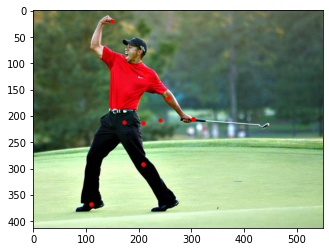

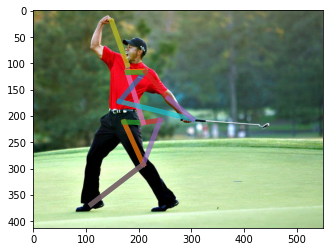

In [37]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 2 epoch

In [38]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-2-loss-1.3551.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

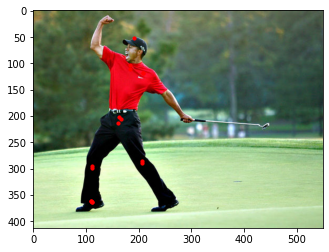

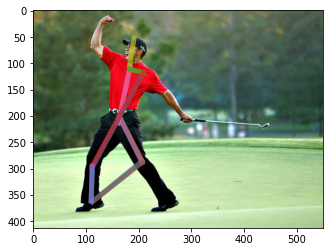

In [39]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 3 epoch

In [42]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-3-loss-1.2693.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

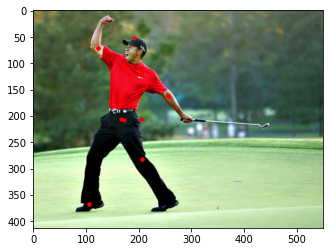

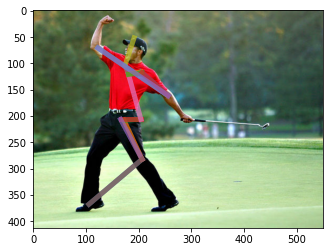

In [43]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 4 epoch

In [44]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-4-loss-1.2260.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

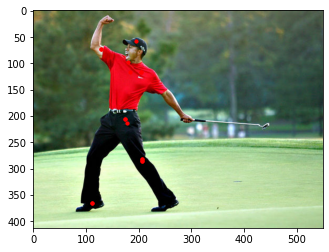

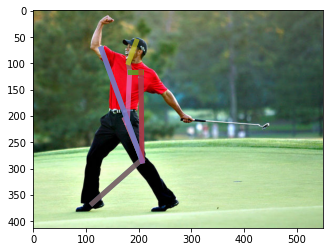

In [45]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 5 epoch

In [ ]:
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'model-epoch-5-loss-1.1833.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

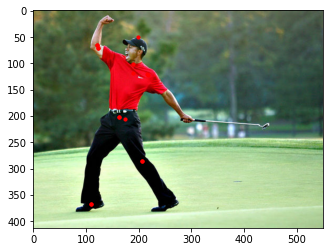

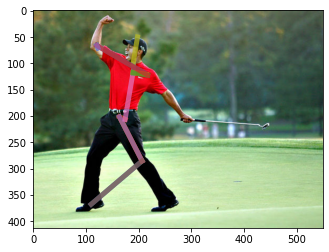

In [ ]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# 16-9. Project: 모델 바꿔보기

**라이브러리 버전 확인**

프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.

In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

## simplebaseline 모델로 변경해 봅시다

지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

<br>

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

<br>

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

## STEP 1 : simplebaseline 모델 완성하기

`simplebaseline.py` 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

## STEP 2 : simplebaseline 모델로 변경하여 훈련하기

StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

## STEP 3 : 두 모델의 비교

실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

<br>

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)

<br>

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

# 회고

## 1. 에러!

![](https://velog.velcdn.com/images/seona056/post/9a1bddba-696f-4c63-89c0-b8ed5c26a302/image.png)

주어진 코드 그대로 했는데도 안되는 에러가 있었음. <br>
```
best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)
``` 
위의 코드 였는데, **Read-only file system** 에러라서 대체 무슨일인가 했더니, `models`폴더가 읽기 전용이었던 모양 <br>
cs님이 알려주셔서 다른 폴더(`save models`)를 생성해서 저장함

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. tfrecord를 활용한 데이터셋 구성과 전처리를 통해 프로젝트 베이스라인 구성을 확인하였다.|MPII 데이터셋을 기반으로 1epoch에 30분 이내에 학습가능한 베이스라인을 구축하였다.|
|2. simplebaseline 모델을 정상적으로 구현하였다.|simplebaseline 모델을 구현하여 실습코드의 모델을 대체하여 정상적으로 학습이 진행되었다.|
|3. Hourglass 모델과 simplebaseline 모델을 비교분석한 결과를 체계적으로 정리하였다.|두 모델의 pose estimation 테스트결과 이미지 및 학습진행상황 등을 체계적으로 비교분석하였다.|